# Bubble segementation: to train the model

If you use google colab, you just have to execute the code of this notebook. To do so you have to click on "ouvrir en mode brouillon" on the upper panel. The training images, the test images and the model will be load from github. The path are already adapted for this.

In [2]:
# Install required libs

!pip install -U git+https://github.com/albu/albumentations
!git clone https://github.com/qubvel/segmentation_models
!pip install -U efficientnet
!pip install image-classifiers==1.0.0b1

import os
import cv2
import keras
import numpy as np
import matplotlib.pyplot as plt
import segmentation_models as sm
import albumentations as A
from albumentations import GridDistortion, OpticalDistortion, HueSaturationValue

Using TensorFlow backend.


Segmentation Models: using `keras` framework.


# Loading dataset and model

The data set and the pretrained model are imported from github.

In [3]:
print('Loading data and model...')
!git clone https://github.com/larrygoyeau/bubble_segmentation
print('Done!')

Loading data and model...
Cloning into 'bubble_segmentation'...
remote: Enumerating objects: 26, done.
remote: Counting objects: 100% (26/26), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 70 (delta 14), reused 0 (delta 0), pack-reused 44
Unpacking objects: 100% (70/70), done.
Done!


If you want to add some new test images or some training samples, you just need to drag images to the different folders in bubble_segmentation/data_set which apear in the left panel (file section) in colab.

In [0]:
DATA_DIR = '/content/bubble_segmentation/data_set'

x_train_dir = os.path.join(DATA_DIR, 'image_train')
interior_y_train_dir = os.path.join(DATA_DIR, 'interior_mask_train')
contour_y_train_dir = os.path.join(DATA_DIR, 'contour_mask_train')

x_valid_dir = os.path.join(DATA_DIR, 'image_validation')
interior_y_valid_dir = os.path.join(DATA_DIR, 'interior_mask_validation')
contour_y_valid_dir = os.path.join(DATA_DIR, 'contour_mask_validation')

x_test_dir = os.path.join(DATA_DIR, 'image_test')

# Dataloader and utility functions 

In [0]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(20, 10))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()
    
# helper function for data visualization    
def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x
    

# classes for data loading and preprocessing
class Dataset:
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    def __init__(
            self, 
            images_dir, 
            masks_dir=None, 
            contour_masks_dir=None,
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids_image = os.listdir(images_dir)
        
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids_image]
        if masks_dir!=None:
          self.contour_masks_fps = [os.path.join(contour_masks_dir,'contour_mask'+image_id[5:]) for image_id in self.ids_image]
          self.masks_fps = [os.path.join(masks_dir,'mask'+image_id[5:]) for image_id in self.ids_image]
        else:
          self.contour_masks_fps=None
          self.masks_fps = None
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        p=255/(image.max()-image.min())
        image=(image-image.min())*p
        image= image.astype(np.uint8)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.contour_masks_fps!=None:
          mask = cv2.imread(self.masks_fps[i], 0)
          contour_mask = cv2.imread(self.contour_masks_fps[i], 0)
          I=len(mask)
          J=len(mask[0])
          for i in range(I):
            for j in range(J):
              if mask[i,j]<5:
                mask[i,j]=1
              else:
                mask[i,j]=0
              if contour_mask[i,j]<8:
                contour_mask[i,j]=1
              else:
                contour_mask[i,j]=0
          mask=np.stack([mask,contour_mask], axis=-1).astype('float')
        else:
          mask=None

        # add background if mask is not binary
        if str(mask)!='None' and mask.shape[-1] != 1:
          background = 1 - mask.sum(axis=-1, keepdims=True)
          mask = np.concatenate((mask, background), axis=-1)
        
        # apply augmentations
        if self.augmentation:
          I=len(image)
          J=len(image[0])
          sample = self.augmentation(I,J)(image=image, mask=mask)
          image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.ids_image)
    
    
class Dataloder(keras.utils.Sequence):
    """Load data from dataset and form batches
    
    Args:
        dataset: instance of Dataset class for image loading and preprocessing.
        batch_size: Integet number of images in batch.
        shuffle: Boolean, if `True` shuffle image indexes each epoch.
    """
    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

        self.on_epoch_end()

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        # transpose list of lists
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return batch
    
    def __len__(self):
        """Denotes the number of batches per epoch"""
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        """Callback function to shuffle indexes each epoch"""
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)   

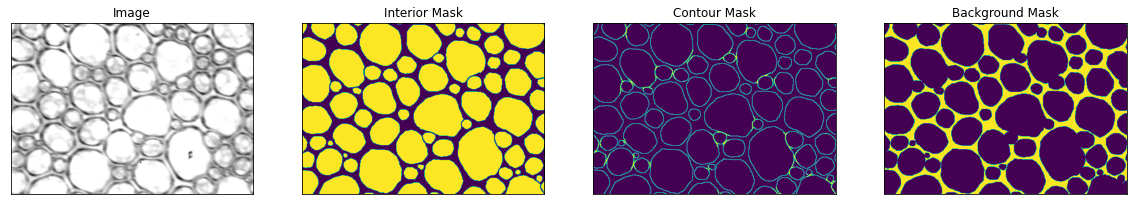

In [6]:
# Lets look at data we have
dataset = Dataset(x_train_dir, interior_y_train_dir, contour_y_train_dir)

image, mask = dataset[1] # get some sample
visualize(
    image=image,
    interior_mask=mask[..., 0].squeeze(),
    contour_mask=mask[..., 1].squeeze(),
    background_mask=mask[..., 2].squeeze())

### Augmentations

Data augmentation is a powerful technique to increase the amount of your data and prevent model overfitting.

Since our dataset is very small we will apply a large number of different augmentations:
 - horizontal flip
 - affine transforms
 - perspective transforms
 - brightness/contrast/colors manipulations
 - image bluring and sharpening
 - gaussian noise
 - random crops

All this transforms can be easily applied with [**Albumentations**](https://github.com/albu/albumentations/) - fast augmentation library.
For detailed explanation of image transformations you can look at [kaggle salt segmentation exmaple](https://github.com/albu/albumentations/blob/master/notebooks/example_kaggle_salt.ipynb) provided by [**Albumentations**](https://github.com/albu/albumentations/) authors.


In [0]:
def round_clip_0_1(x, **kwargs):
    return x.round().clip(0, 1)

# define heavy augmentations
def get_training_augmentation(I,J):
    train_transform = [

        A.HorizontalFlip(p=0.5),

        A.ShiftScaleRotate(scale_limit=0.2, rotate_limit=90, shift_limit=0, p=2, border_mode=0),

        A.PadIfNeeded(min_height=384, min_width=544, border_mode=0),
        #A.RandomCrop(height=384, width=544, always_apply=True),

        #A.IAAAdditiveGaussianNoise(p=0.2),
        A.IAAPerspective(p=0.5),

        
        A.RGBShift(p=0.3),
        A.ElasticTransform(p=0.3,alpha=10, sigma=120 * 0.05, alpha_affine=120 * 0.03),
        A.Flip(),
        A.HorizontalFlip(),
        A.VerticalFlip(),
        #A.Transpose(),

        A.OneOf(
            [
                A.CLAHE(p=1),
                A.RandomBrightness(limit=0.05,p=1),
                A.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.IAASharpen(p=1),
                #A.Blur(blur_limit=2, p=1),
                A.MotionBlur(blur_limit=5, p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                #A.RandomContrast(limit=0.1,p=1),
                A.HueSaturationValue(p=1),
            ],
            p=0.5,
        ),
        A.Lambda(mask=round_clip_0_1),
        
        A.OneOf([
            OpticalDistortion(distort_limit=0.5, shift_limit=1, border_mode=0),
            GridDistortion(border_mode=0),
        ], p=0.9)
    ]
    return A.Compose(train_transform)


def get_validation_augmentation(I,J):
    """Add paddings to make image shape divisible by 32"""
    if (I,J)==(384,544):
      test_transform = [A.PadIfNeeded(I, J, border_mode=0)]
    elif np.log(I)/np.log(2)%1==0 and np.log(J)/np.log(2)%1==0:
      test_transform = [A.PadIfNeeded(I, J, border_mode=0)]
    elif np.log(I)/np.log(2)%1==0:
      test_transform = [A.PadIfNeeded(I, 2**(int(np.log(J)/np.log(2))+1), border_mode=0)]
    elif np.log(J)/np.log(2)%1==0:
      test_transform = [A.PadIfNeeded( 2**(int(np.log(I)/np.log(2))+1), J, border_mode=0)]
    else:
      test_transform = [A.PadIfNeeded(2**(int(np.log(I)/np.log(2))+1), 2**(int(np.log(J)/np.log(2))+1), border_mode=0)]
    return A.Compose(test_transform)

def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        A.Lambda(image=preprocessing_fn),
    ]
    return A.Compose(_transform)

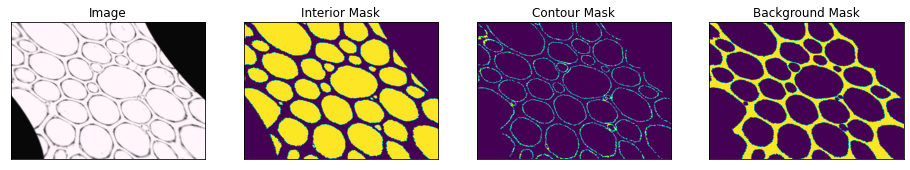

In [0]:
# Lets look at augmented data we have
dataset = Dataset(x_train_dir, interior_y_train_dir, contour_y_train_dir, augmentation=get_training_augmentation)

image, mask = dataset[7] # get some sample
visualize(
    image=image,
    interior_mask=mask[..., 0].squeeze(),
    contour_mask=mask[..., 1].squeeze(),
    background_mask=mask[..., 2].squeeze()
    )

# Segmentation model training

In [0]:
BACKBONE = 'efficientnetb3'
BATCH_SIZE = 1
LR = 0.0001

preprocess_input = sm.get_preprocessing(BACKBONE)

# define network parameters
n_classes =3 # case for binary and multiclass segmentation
activation = 'softmax'

#create model
model = sm.Unet(BACKBONE, classes=n_classes, activation=activation)












Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
44113920/44107200 [==============================] - 1s 0us/step




In [12]:
# define optomizer
optim = keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
# set class weights for dice_loss (car: 1.; pedestrian: 2.; background: 0.5;)
dice_loss = sm.losses.DiceLoss(class_weights=np.array([1, 2, 0.5])) 
focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# The model is load. This model is already trained
model.load_weights("/content/bubble_segmentation/best_model.h5")
print("Loaded model from disk")

# compile keras model with defined optimozer, loss and metrics
model.compile(optim, total_loss, metrics)

Loaded model from disk




In [0]:
# Dataset for train images
train_dataset = Dataset(
    x_train_dir, 
    interior_y_train_dir,
    contour_y_train_dir,
    augmentation=get_training_augmentation,
    preprocessing=get_preprocessing(preprocess_input),
)

# Dataset for validation images
valid_dataset = Dataset(
    x_valid_dir, 
    interior_y_valid_dir, 
    contour_y_valid_dir,
    augmentation=get_validation_augmentation,
    preprocessing=get_preprocessing(preprocess_input),
)

train_dataloader = Dataloder(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = Dataloder(valid_dataset, batch_size=1, shuffle=False)

# check shapes for errors
assert train_dataloader[0][0].shape == (BATCH_SIZE, 384, 544, 3)
assert train_dataloader[0][1].shape == (BATCH_SIZE, 384, 544, n_classes)

The weights of the model will be saved on bubble_segmentation/best_model.h5

In [0]:
# define callbacks for learning rate scheduling and best checkpoints saving
callbacks = [
    keras.callbacks.ModelCheckpoint('/content/bubble_segmentation/best_model.h5', save_weights_only=True, save_best_only=True, mode='min'),
    keras.callbacks.ReduceLROnPlateau(),
]

In [15]:
# train model
history = model.fit_generator(
    train_dataloader, 
    steps_per_epoch=len(train_dataloader),
    epochs=3, #You can increase the number of iterations
    callbacks=callbacks, 
    validation_data=valid_dataloader, 
    validation_steps=len(valid_dataloader),
)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/10
8/8 [==============================] - 44s 5s/step - loss: 0.3579 - iou_score: 0.4946 - f1-score: 0.5958 - val_loss: 0.1728 - val_iou_score: 0.6989 - val_f1-score: 0.8069
Epoch 2/10
8/8 [==============================] - 2s 232ms/step - loss: 0.3482 - iou_score: 0.4831 - f1-score: 0.5880 - val_loss: 0.1605 - val_iou_score: 0.7189 - val_f1-score: 0.8215
Epoch 3/10
8/8 [==============================] - 4s 446ms/step - loss: 0.2912 - iou_score: 0.5363 - f1-score: 0.6373 - val_loss: 0.1530 - val_iou_score: 0.7189 - val_f1-score: 0.8216
Epoch 4/10
8/8 [==============================] - 5s 575ms/step - loss: 0.2959 - iou_score: 0.5176 - f1-score: 0.6198 - val_loss: 0.1476 - val_iou_score: 0.7194 - val_f1-score: 0.8217
Epoch 5/10
8/8 [==============================] - 5s 565ms/step - loss: 0.3039 - iou_score: 0.5065 - f1-score: 0.6068 - val_loss: 0.1433 - val_iou_score: 0.7207 - val_f1-

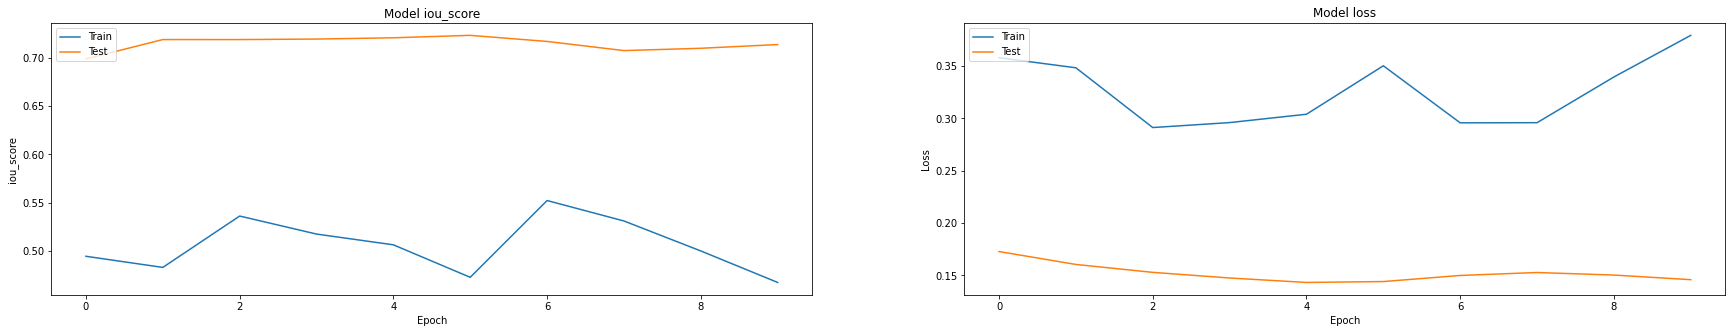

In [21]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Model Evaluation

In [0]:
# load best weights
model.load_weights('/content/bubble_segmentation/best_model.h5')

In [23]:
scores = model.evaluate_generator(valid_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

Loss: 0.14332
mean iou_score: 0.72073
mean f1-score: 0.82262


In [0]:
import sys
sys.setrecursionlimit(100000)

def color_bubble(mask,i,j,I,J,bubble,color):
  if all(mask[i,j]==color) and (i,j)!=(0,0):
    mask[0,0][0]=mask[0,0][0]+1   #size bubble
    mask[i,j]=[bubble%253+2, bubble%85+20, bubble%170+2]
    if 0<j:
      color_bubble(mask,i,j-1,I,J,bubble,color)
    if i<I-1:
      color_bubble(mask,i+1,j,I,J,bubble,color)
    if 0<i:
      color_bubble(mask,i-1,j,I,J,bubble,color)
    if j<J-1:
      color_bubble(mask,i,j+1,I,J,bubble,color)
    
def uncolor_bubble(mask,i,j,I,J,color_liquide,color):
  if all(mask[i,j]==[color%253+2, color%85+20, color%170+2]):
    mask[i,j]=color_liquide
    if 0<j:
      uncolor_bubble(mask,i,j-1,I,J,color_liquide,color)
    if i<I-1:
      uncolor_bubble(mask,i+1,j,I,J,color_liquide,color)
    if 0<i:
      uncolor_bubble(mask,i-1,j,I,J,color_liquide,color)
    if j<J-1:
      uncolor_bubble(mask,i,j+1,I,J,color_liquide,color)
    
# The fonuction bellow will color each bubbles

def foam(mask,color_air,threshold,color_liquide):
  I=len(mask)
  J=len(mask[0])
  bubble=0
  n=0
  for i in range(I):
    for j in range(J):
      if all(mask[i,j]==color_air):
        mask[0,0][0]=0
        color_bubble(mask,i,j,I,J,bubble,color_air)
        size_bubble=mask[0,0][0]
        if size_bubble<threshold:
          uncolor_bubble(mask,i,j,I,J,color_liquide,bubble)
        else:
          bubble=bubble+40
          n=n+1
  print("Number of detected bubbles "+str(n))

# Visualization of results on test dataset

Number of detected bubbles 174


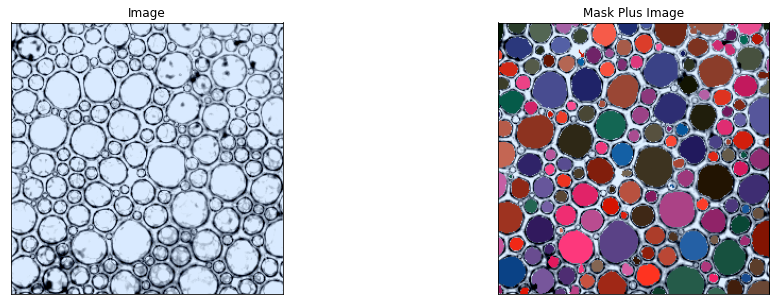

Number of detected bubbles 11


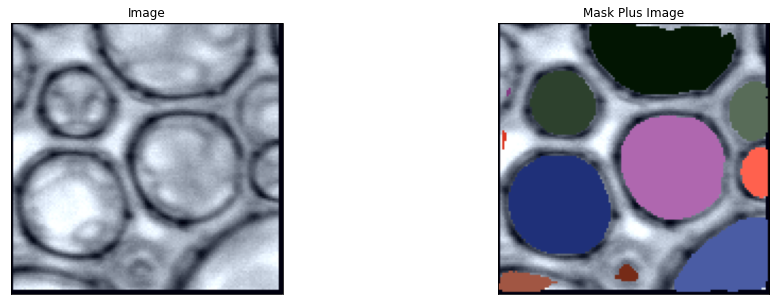

Number of detected bubbles 83


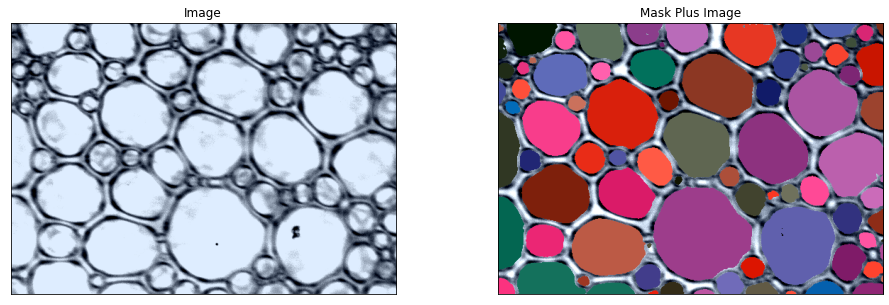

Number of detected bubbles 90


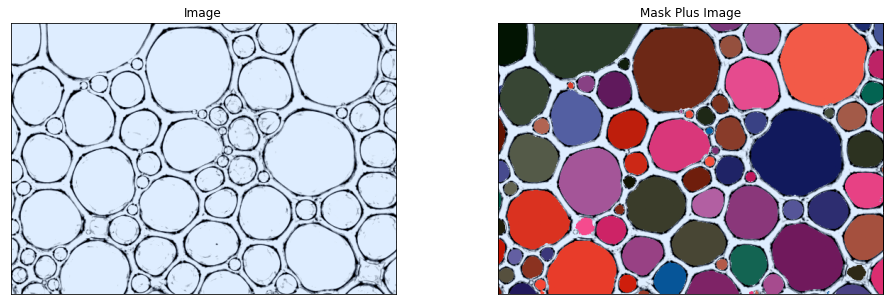

In [25]:
test_dataset = Dataset(
    x_test_dir,
    preprocessing=get_preprocessing(preprocess_input),
    augmentation=get_validation_augmentation
)

n =len(os.listdir(x_test_dir))
liste_mask_plus_image=[]

for i in range(n):
    image, gt_mask = test_dataset[i]
    image = np.expand_dims(image, axis=0)
    pr_mask = model.predict(image).round()[0]
    foam(pr_mask[:,:-1], color_air=[1,0,0],threshold=5,color_liquide=[0,1,0])

    image=denormalize(image.squeeze())
    I=len(image)
    J=len(image[0])
    mask_plus_image=pr_mask.copy()
    for i in range(I):
      for j in range(J):
        if pr_mask[i,j][2]==1.0 or pr_mask[i,j][1]==1.0 or all(pr_mask[i,j]==0):
          mask_plus_image[i,j]=image[i,j]*255

    liste_mask_plus_image=liste_mask_plus_image+[mask_plus_image]
    
    visualize(
        image=image,
        #pr_mask=pr_mask.squeeze(),
        mask_plus_image=denormalize(mask_plus_image.squeeze())
    )

To save the segmentations run the below code and if you use google colab clic on "actualiser" on the left panel "fichiers" to see files.

In [0]:
i=0
for mask_plus_image in liste_mask_plus_image:
    cv2.imwrite('mask_plus_image_'+str(i)+'.png', mask_plus_image)
    i=i+1